Params: K=2, max_iter=100, tol=0.0001 -> CV Silhouette=0.3842
Params: K=2, max_iter=100, tol=0.001 -> CV Silhouette=0.3842
Params: K=2, max_iter=300, tol=0.0001 -> CV Silhouette=0.3842
Params: K=2, max_iter=300, tol=0.001 -> CV Silhouette=0.3842
Params: K=3, max_iter=100, tol=0.0001 -> CV Silhouette=0.3469
Params: K=3, max_iter=100, tol=0.001 -> CV Silhouette=0.3469
Params: K=3, max_iter=300, tol=0.0001 -> CV Silhouette=0.3469
Params: K=3, max_iter=300, tol=0.001 -> CV Silhouette=0.3469
Params: K=4, max_iter=100, tol=0.0001 -> CV Silhouette=0.2909
Params: K=4, max_iter=100, tol=0.001 -> CV Silhouette=0.2909
Params: K=4, max_iter=300, tol=0.0001 -> CV Silhouette=0.2909
Params: K=4, max_iter=300, tol=0.001 -> CV Silhouette=0.2909
Params: K=5, max_iter=100, tol=0.0001 -> CV Silhouette=0.3262
Params: K=5, max_iter=100, tol=0.001 -> CV Silhouette=0.3260
Params: K=5, max_iter=300, tol=0.0001 -> CV Silhouette=0.3262
Params: K=5, max_iter=300, tol=0.001 -> CV Silhouette=0.3260

=== Meilleurs p

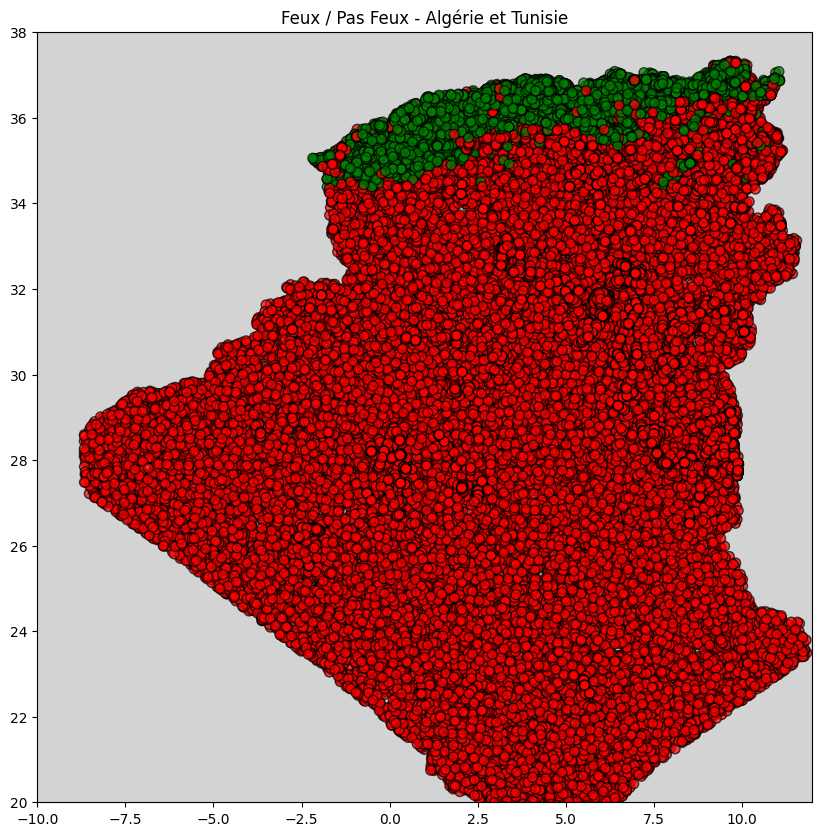

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score, accuracy_score, classification_report
from collections import Counter
import matplotlib.pyplot as plt
import os

# --- CONFIGURATION ---
CHEMIN_FICHIER = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\preparing\\Final_Reduit30_70.csv'
COLONNE_CIBLE = 'classe'
DOSSIER_PLOTS = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\Results\\plots_clustering'
if not os.path.exists(DOSSIER_PLOTS):
    os.makedirs(DOSSIER_PLOTS)

# --- Chargement et préparation des données ---
df = pd.read_csv(CHEMIN_FICHIER)
if 'latitude' not in df.columns or 'longitude' not in df.columns:
    raise ValueError("Le fichier doit contenir les colonnes 'latitude' et 'longitude'")

X = df.drop(columns=[COLONNE_CIBLE, 'latitude', 'longitude'], errors='ignore')
y = df[COLONNE_CIBLE]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- K-Means from scratch ---
class KMeansFromScratch:
    def __init__(self, n_clusters=2, max_iter=300, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.centroids = None
        self.labels_ = None

    def _initialize_centroids(self, X):
        np.random.seed(self.random_state)
        indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        return X[indices]

    def _assign_clusters(self, X, centroids):
        distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
        return np.argmin(distances, axis=0)

    def _update_centroids(self, X, labels):
        new_centroids = np.zeros((self.n_clusters, X.shape[1]))
        for i in range(self.n_clusters):
            cluster_points = X[labels == i]
            if len(cluster_points) > 0:
                new_centroids[i] = cluster_points.mean(axis=0)
            else:
                new_centroids[i] = self.centroids[i]  # si cluster vide, garder ancien
        return new_centroids

    def fit(self, X):
        X = np.array(X)
        self.centroids = self._initialize_centroids(X)
        for _ in range(self.max_iter):
            labels = self._assign_clusters(X, self.centroids)
            new_centroids = self._update_centroids(X, labels)
            if np.all(np.abs(new_centroids - self.centroids) < self.tol):
                break
            self.centroids = new_centroids
        self.labels_ = labels
        return self

    def predict(self, X):
        return self._assign_clusters(np.array(X), self.centroids)

# --- Grid Search et Cross Validation ---
param_grid = {
    'n_clusters': [2, 3, 4, 5],  # on peut tester plusieurs k
    'max_iter': [100, 300],
    'tol': [1e-4, 1e-3]
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_score = -np.inf
best_params = None

for n_clusters in param_grid['n_clusters']:
    for max_iter in param_grid['max_iter']:
        for tol in param_grid['tol']:
            sil_scores = []
            for train_index, val_index in kf.split(X_scaled):
                X_train, X_val = X_scaled[train_index], X_scaled[val_index]
                y_val = y.iloc[val_index]

                kmeans = KMeansFromScratch(n_clusters=n_clusters, max_iter=max_iter, tol=tol, random_state=42)
                kmeans.fit(X_train)
                labels_val = kmeans.predict(X_val)
                sil_scores.append(silhouette_score(X_val, labels_val))

            mean_sil = np.mean(sil_scores)
            print(f"Params: K={n_clusters}, max_iter={max_iter}, tol={tol} -> CV Silhouette={mean_sil:.4f}")
            if mean_sil > best_score:
                best_score = mean_sil
                best_params = {'n_clusters': n_clusters, 'max_iter': max_iter, 'tol': tol}

print("\n=== Meilleurs paramètres trouvés ===")
print(best_params)
print(f"Silhouette Score moyen CV: {best_score:.4f}")

# --- Fit final sur toutes les données avec les meilleurs paramètres ---
kmeans_final = KMeansFromScratch(**best_params, random_state=42)
kmeans_final.fit(X_scaled)
labels_final = kmeans_final.labels_

# Mapper clusters → classes
cluster_to_class = {}
for c in np.unique(labels_final):
    mask = labels_final == c
    majority_class = Counter(y[mask]).most_common(1)[0][0]
    cluster_to_class[c] = majority_class

y_pred_final = [cluster_to_class[label] for label in labels_final]

print(f"\nAccuracy final: {accuracy_score(y, y_pred_final)*100:.2f}%")
print(classification_report(y, y_pred_final))

# --- Carte finale ---
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlim([-10, 12])
ax.set_ylim([20, 38])
ax.set_facecolor('lightgray')
ax.set_title('Feux / Pas Feux - Algérie et Tunisie')
colors = ['red' if c==1 else 'green' for c in labels_final]
ax.scatter(df['longitude'], df['latitude'], c=colors, s=50, alpha=0.7, edgecolor='k')
plt.savefig(os.path.join(DOSSIER_PLOTS, 'map_FEU_clusters_best.png'), dpi=300)
plt.show()